Response to Kaggle competition: https://www.kaggle.com/c/costa-rican-household-poverty-prediction/overview

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.utils import resample

%matplotlib inline

This dataset is characterised by having a large number of features with a number of data quality issues throughout.
My effort is therefore focussed on automating an approach to identifying, for each feature (1) what kind of feature it is and (2) any potential major data quality issues such as
- Range and distribution checks
- Missing data
- Poorly encoded data
- Data integrity issues between households and individuals

# Load data and create a data dictionary

In [2]:
# Load the supplied CSV using pandas
train_data = pd.read_csv("train.csv")

# Review the features and the shape of the dataset
print "The train dataset contains %d rows and %d features" % train_data.shape

# This function detects the feature type by counting the number of distinct values
def detect_type(c):
    if c == 0: return "Empty"
    elif c == 1: return "Invariant"
    elif c == 2: return "Binary"
    else: return "Other"

# The Kaggle entry provides a data dictionary which I have saved as a CSV and loaded.
# I augment this information from Kaggle with the value counts, the feature type as detected
# by the function above and by Pandas. 
data_dictionary = pd.read_csv("data_dictionary.csv", escapechar='\\')
data_dictionary["Value Counts"] = data_dictionary["Feature"].apply(lambda feature: train_data[feature].nunique())
data_dictionary["Detected Type"] = data_dictionary["Value Counts"].apply(lambda count: detect_type(count))
data_dictionary["Pandas Type"] = data_dictionary["Feature"].apply(lambda feature: train_data[feature].dtype)

The train dataset contains 9557 rows and 143 features


In [3]:
# Display the data dictionary
with pd.option_context('display.max_rows', None, 'display.max_columns', None): display(
    data_dictionary.sort_values(by="Detected Type")
                        )

,Feature,Description,Value Counts,Detected Type,Pandas Type
70,eviv2,=1 if floor are regular,2,Binary,int64
80,estadocivil6,=1 if widow/er,2,Binary,int64
79,estadocivil5,=1 if separated,2,Binary,int64
78,estadocivil4,=1 if divorced,2,Binary,int64
77,estadocivil3,=1 if married,2,Binary,int64
76,estadocivil2,=1 if free or coupled uunion,2,Binary,int64
75,estadocivil1,=1 if less than 10 years old,2,Binary,int64
74,female,=1 if female,2,Binary,int64
73,male,=1 if male,2,Binary,int64
72,dis,=1 if disable person,2,Binary,int64


In [4]:
# Using this data dictionary, I create three lists of features - binary, discrete, continuous
# This is a mixture of auto-detecting the feature type, and handcrafting the numerical feature lists. 

features_categorical = list(data_dictionary[data_dictionary["Detected Type"] == "Binary"]["Feature"])

features_numerical_discrete = [
    "SQBhogar_total",
    "SQBage", "SQBescolari", "age", "qmobilephone", "SQBedjefe",
    "SQBhogar_nin", "rooms", "v18q1", "r4h1", "r4h2", "r4h3",
    "r4m1", "r4m2", "r4m3", "r4t1", "r4t2", "r4t3", "tamhog",
    "tamviv", "escolari", "rez_esc", "hhsize", "hogar_adul",
    "hogar_nin", "hogar_mayor", "hogar_total", "edjefe", "edjefa",
    "bedrooms", "agesq"
]

features_numerical_continuous = [
    "SQBdependency", "dependency", "v2a1", "meaneduc", "SQBmeaned", "overcrowding", "SQBovercrowding"
]

# Print the size of each subgroup of features, as well as the overall size of features
features = set(train_data.columns)
print "Total Features: %d" % len(features)
print "Categorical Features: %d. Numerical Discrete Features: %d. Numerical Continuous Features: %d." \
    % (len(features_categorical), len(features_numerical_discrete), len(features_numerical_continuous))

# Take a delta between the overall list and the subgroups created
features_delta = features \
    - set(features_categorical) \
    - set(features_numerical_discrete) \
    - set(features_numerical_continuous)

# Print out the delta
print "Features in the original feature list, but not in one of the subsets:"
for feature in features_delta: print "* %s" %feature


Total Features: 143
Categorical Features: 101. Numerical Discrete Features: 31. Numerical Continuous Features: 7.
Features in the original feature list, but not in one of the subsets:
* idhogar
* Target
* elimbasu5
* Id


I can see the only features not captured by these groupings are the ID, the Target, an invariant feature we can drop and the grouping feature.

In the data dictionary above, we can see that three of the features are not numbers but 'objects'. On investigation, we can see pandas has interpreted them this way because they contain both numbers, and the strings 'yes' and 'no'. The Kaggle discussion guides us to replace these 'yes' and 'no' values with 1 and 0 respectively.

In [5]:
features_object = ["dependency", "edjefe", "edjefa"]

# Replace occurrences of 'yes' and 'no' with numbers in the relevant features, and convert these features to numeric.
train_data[features_object] = train_data[features_object].replace({"yes": 1, "no": 0})

# Having replaced the values 'yes' and 'no' with numbers, we can convert those features to numeric features
for feature in features_object:
    train_data[feature] = pd.to_numeric(train_data[feature])

Next I plot each numerical feature so I can begin to understand its distribution and sense check it

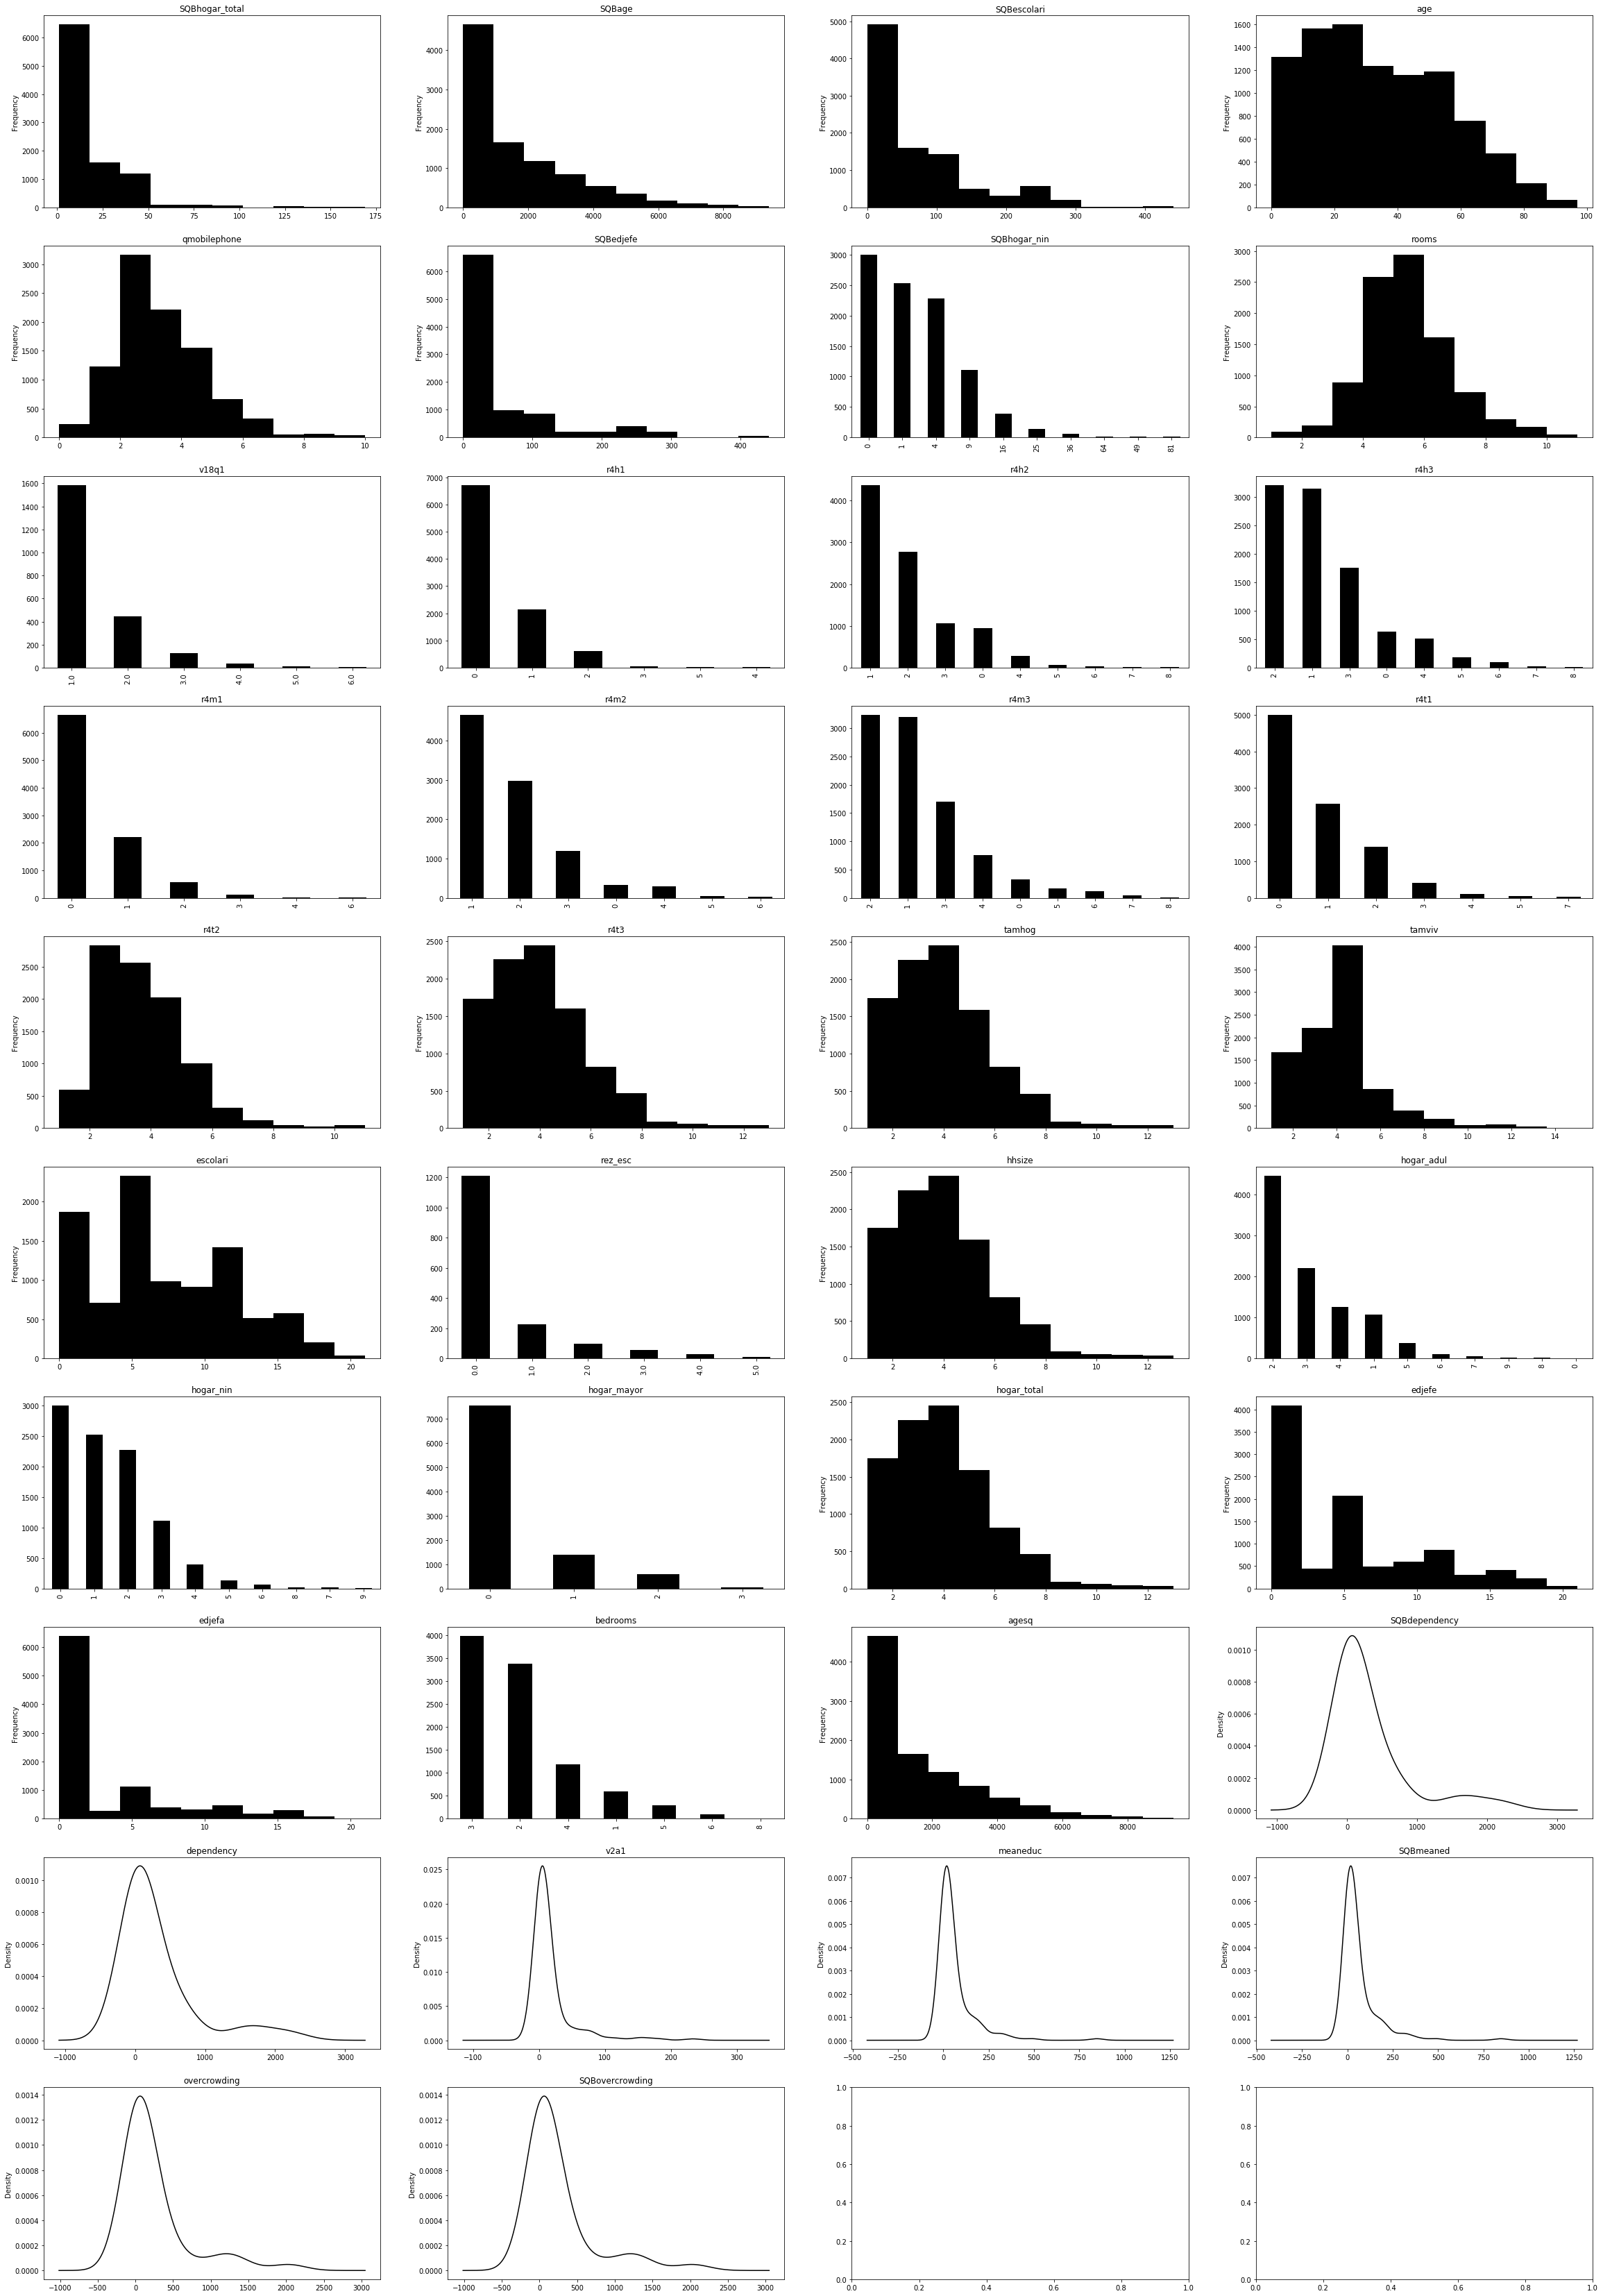

In [6]:
# This function generates ax IDs for the plot across the grid
def generateAxes(rows, cols):
    id = 0
    while id < 100 * cols:
        yield_x = id // cols
        yield_y = id % cols
        yield (yield_x, yield_y)
        id += 1

# Instance of our ax ID generator
axIDs = generateAxes(10, 4)

# Create the subplot
fig, ax = plt.subplots(10, 4, figsize=(40,60))

# Plot each discrete feature as a bar chart or histogram
for feature in features_numerical_discrete:
    axID = axIDs.next()
    if data_dictionary.set_index("Feature").loc[feature, "Value Counts"] <= 10:
        train_data[feature].value_counts().plot(kind = "bar", ax = ax[axID], color="k")
    else:
        train_data[feature].plot(kind = "hist", ax = ax[axID], color="k")
    ax[axID].set_title(feature)
    
# Plot each continuous feature as a KDE plot
for feature in features_numerical_continuous:
    axID = axIDs.next()
    train_data[feature].value_counts().plot(kind = "kde", ax = ax[axID], color="k")
    ax[axID].set_title(feature)

With each of these plots, I have done a manual sense check on the feature using limited domain knowledge, looking particularly at range and distribution and saw no issues.

In [7]:
# For the binary features, we simply print a list of the value counts for 0/1 for each feature to sense check them.

# This function returns the distribution for a binary feature. For non-binary features it returns nothing.
def value_counts(feature):
    if len(train_data[feature].value_counts()) == 2:
        return train_data[feature].value_counts().values
    else: return ""
    
data_dictionary["Value Counts (Binary)"] = data_dictionary["Feature"].apply(value_counts)

# We temporarily increase the max_rows for dataframes displaying so we can see all the values
with pd.option_context('display.max_rows', None, 'display.max_columns', None): display(
    data_dictionary[data_dictionary["Detected Type"] == "Binary"]
)

,Feature,Description,Value Counts,Detected Type,Pandas Type,Value Counts (Binary)
1,hacdor,=1 Overcrowding by bedrooms,2,Binary,int64,"[9193, 364]"
3,hacapo,=1 Overcrowding by rooms,2,Binary,int64,"[9331, 226]"
4,v14a,=1 has bathroom in the household,2,Binary,int64,"[9507, 50]"
5,refrig,=1 if the household has refrigerator,2,Binary,int64,"[9152, 405]"
6,v18q,owns a tablet,2,Binary,int64,"[7342, 2215]"
22,paredblolad,=1 if predominant material on the outside wal...,2,Binary,int64,"[5677, 3880]"
23,paredzocalo,"""=1 if predominant material on the outside wa...",2,Binary,int64,"[8814, 743]"
24,paredpreb,=1 if predominant material on the outside wal...,2,Binary,int64,"[7760, 1797]"
25,pareddes,=1 if predominant material on the outside wal...,2,Binary,int64,"[9475, 82]"
26,paredmad,=1 if predominant material on the outside wal...,2,Binary,int64,"[8452, 1105]"


Again, for each of these binary features, I have checked the distribution of 0s and 1s against my limited domain knowledge.

# Data Integrity Issues

We are told that households are defined by having the same value for 'idhogar'. I check whether, within households, individuals always have the same target

In [8]:
# Create a new dataframe at the household level
unique_households = pd.DataFrame({"idhogar" : train_data["idhogar"].unique()})

# This function returns the number of distinct targets within the household
def count_distinct_targets(id):
    return train_data[train_data["idhogar"] == id]["Target"].nunique()

# Count distinct targets for each households and print the sum of those with more than one target level
unique_households["Distinct Targets"] = unique_households["idhogar"].apply(count_distinct_targets)
print "Number of households with more than one poverty level represented: %d" % \
        sum(unique_households["Distinct Targets"] > 1)

Number of households with more than one poverty level represented: 85


There are 85 households where there is more than one value of poverty recorded for individuals in the household. The kaggle data brief tells us this shouldn't happen, so I should consider replacing the target for these individuals with their head of household's.

I am also interested in whether there are any households without a head or any households with more than one head.

In [9]:
# This function counts how many household heads there are for the passed household id.
def count_heads(id):
    return sum((train_data["idhogar"] == id) & (train_data["parentesco1"] == 1))

# Apply our function across the unique households
unique_households["Count of Household Heads"] = unique_households["idhogar"].apply(count_heads)

# Print a summary of number household heads
print "Households with more than one head: %d" % \
        sum(unique_households["Count of Household Heads"] > 1)
print "Households without a head: %d" % \
        sum(unique_households["Count of Household Heads"] == 0)

Households with more than one head: 0
Households without a head: 15


In [10]:
# For those households with more than 1 head,
# we should see if the household level chracteristics are the same across them
headless_households = unique_households[unique_households["Count of Household Heads"] == 0]["idhogar"].values

# We need to check if any headless households have inconsistent Targets (it appears none do)
# This should print True 
print all(count_distinct_targets(household_id) == 1 for household_id in headless_households)

True


We fix the first data integrity issue of different targets across households by forcing the target to be that of the household head

In [11]:
# This function returns the correct target for a given household ID
def get_target_for_household(id):
    return train_data[
        (train_data["idhogar"] == id) &
        (train_data["parentesco1"] == 1)
                    ]["Target"].iloc[0]

# Create a list of households we need to fix
households_with_multiple_targets = unique_households[unique_households["Distinct Targets"] > 1]["idhogar"]

# Iterate through those we intend to fix and update the Target for each
for household in households_with_multiple_targets:
    train_data.loc[train_data.idhogar == household, "Target"] = get_target_for_household(household)

# Missing Data
I iterate through the features, and count the number of missing values in each feature

In [12]:
# Iterate through the features, for those with missing values, print the count and percentage of missing values
for feature in train_data.columns:
    count_na = train_data[feature].isnull().sum()
    if count_na > 0:
        percentage_missing = "{:.1%}".format(count_na/len(train_data))
        print "%s: missing %d values. As percentage: %s" % (feature, count_na, percentage_missing)

v2a1: missing 6860 values. As percentage: 71.8%
v18q1: missing 7342 values. As percentage: 76.8%
rez_esc: missing 7928 values. As percentage: 83.0%
meaneduc: missing 5 values. As percentage: 0.1%
SQBmeaned: missing 5 values. As percentage: 0.1%


Only 5 features seem to contain missing data, so we look at them in turn

__v2a1__

v2a1 is their monthly rent payment. I have a hypothesis that these individuals are either homeless or they own their homes. The features 'tipovivi' describe with dummy variables their housing status so we look at this distribution. In order to do this, I convert the dummy variables to a single feature.

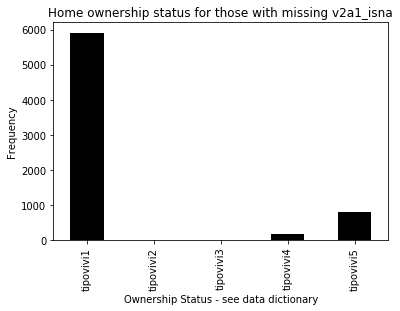

In [13]:
# We want to group by ownership status which is encoded as dummy features, we undo this as follows
home_ownership_features = ["tipovivi1", "tipovivi2", "tipovivi3", "tipovivi4", "tipovivi5"]
train_data["tipovivi"] = train_data[home_ownership_features].idxmax(axis = 1)
train_data["v2a1_isna"] = train_data["v2a1"].isna()

ax = train_data.groupby("tipovivi").sum()["v2a1_isna"].plot(kind = "bar", color="k")
ax.set_title("Home ownership status for those with missing v2a1_isna")
ax.set_xlabel("Ownership Status - see data dictionary")
ax.set_ylabel("Frequency")
plt.show()

This plot suggests that the home ownership status explains the missing data for the majority: they own their property so there is no rental payment to be recorded. We can replace these with zeroes. It's less clear what we should do with category 4 (precarious) or category 5 (other, assigned, borrowed), but by the sounds of the category names I can believe these individuals all have zero rent payments.

__v18q1__

I next look at v18q1 - the number of tablets the household as. I have a strong hypothesis this is NA when the household has no tablets. I check this in a similar way.

In [14]:
train_data["v18q1_isna"] = train_data["v18q1"].isna()
train_data.groupby("v18q").sum()["v18q1_isna"]

v18q
0    7342.0
1       0.0
Name: v18q1_isna, dtype: float64

This tells us that all the values for which the feature is NA coincide with rows where there is not a tablet in the household (v18q = 0). We can safely replace the value of v18q1 with zero.
|
__rez_esc__

Next we look at the 'rez_esc' feature which is the number of years behind they are in school. The Kaggle competition clarifies "This variable is only collected for people between 7 and 19 years of age and it is the difference between the years of education a person should have and the years of education he/she has. It is capped at 5." We can see the NAs are generally explain by individuals not being of school age (with the exception of a single 10 year old).

In [15]:
# For the rows where rez_esc is na, we list the unique ages associated with these individuals
ages_with_rez_esc_na = train_data[train_data["rez_esc"].isna()]["age"].unique()
print sorted(ages_with_rez_esc_na)

[0, 1, 2, 3, 4, 5, 6, 10, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 97]


It's debatable how we should treat this. In this case, NA is meaningful, it's not missing it's just undefined for these individuals. For the sake of progressing, I will replace these values with the mean for the feature but this deserves more careful attention. The main risk of this is it artificially reduces the variance of this feature. 

__meaneduc__ and __SQBmeaned__

Next I look at 'meaneduc' and 'SQBmeaned', which are both missing in 5 rows. There is no obvious reason why these are missing for these 5 individuals. We have a few different choices with these- we could drop the rows, we could use a simple imputation approach or a regression imputation. A complex imputation approach would probably be overkill given this is a tiny volume of the dataset so to progress with the excercise I opt to simply replace with the mean values.

In [16]:
# Replace the NAs with 0s for v18q1 and v2a1
train_data["v18q1"].fillna(0, inplace = True)
train_data["v2a1"].fillna(0, inplace = True)

# Replace the NAs with the mean for meaneduc and SQBmeaned
# we don't do this for rez_esc until after aggregation 
meaneduc_mean = train_data["meaneduc"].mean()
meaneduc_squared_mean = train_data["SQBmeaned"].mean()
train_data["meaneduc"].fillna(meaneduc_mean, inplace = True)
train_data["SQBmeaned"].fillna(meaneduc_squared_mean, inplace = True)

# Distribution of the target
I've looked at all our features, but I also want to understand the distribution of our target (poverty level)

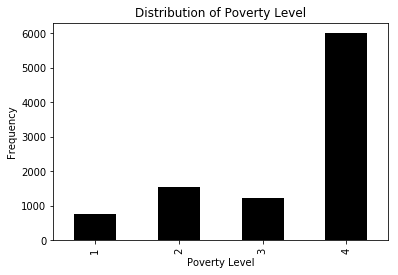

Missing values in Target: 0


In [17]:
# Plot the distribution of the target using pandas
ax = train_data["Target"].value_counts().sort_index().plot(kind="bar", color="black")
ax.set_title("Distribution of Poverty Level")
ax.set_xlabel("Poverty Level")
ax.set_ylabel("Frequency")

# Show the plot
plt.show()

# Count the number of missing values
print "Missing values in Target: %d" % train_data["Target"].isna().sum()

I can see that poverty level 4 (non-vulnerable) is a much larger group than the others, and should bear this class imbalance in mind when we come to model. There are no missing values in the target.

Finally we drop the additional we created to tidy up 

In [18]:
train_data.drop(columns = ["tipovivi", "v2a1_isna", "v18q1_isna"], inplace = True)

# Aggregating features to the household head
The kaggle tells us we will be scored on household heads. We can use all of the features, both the household level features (e.g. bedrooms) and the individual features (e.g.) age. But we can augment our household head with additional data about their household. This is done for three such features below. These were chosen because of my prior assumptions that education and disability might predict poverty.

In [19]:
# Proportion of the household who is disabled and the average number of years behind for the househould
new_features = train_data.groupby("idhogar").mean()[["dis", "rez_esc"]].fillna(0)

new_features.columns = ["proportion_disabled_household", "average_rez_esc_household"]

# Highest level of education for the family
# To get this we have to find convert the dummy features to a single categorical feature 
def highest_level_education(row):
    if (row == 0).all(): # has no education
        return 0
    else:
        return int(row.idxmax()[-1])

# We find the education level for each individual using the above function, then find the max across households
education_features = ["instlevel" + str(x) for x in range(1,10)]
train_data["education_level"] = train_data[education_features].apply(highest_level_education, axis = 1)
max_education_level = train_data.groupby("idhogar").max()[["education_level"]]
max_education_level.columns = ["max_education_level"]

# Add the maximum level of education to the new features 
new_features = pd.merge(new_features, max_education_level, how="inner", left_index=True, right_index=True)

# We drop the categorical feature we created to tidy up
train_data.drop(columns="education_level", inplace = True)

We have created three new features at the household level that we can join on to our household's head.

In [20]:
# Filter our list down to household heads
household_heads = train_data[train_data["parentesco1"] == 1]

# Join our newly engineered fields to the househould head
household_heads = pd.merge(household_heads, new_features, how="inner", left_on="idhogar", right_index = True)

# Finally, we still have NAs in the rez_esc feature, so we must remove these
household_heads["rez_esc"].fillna(0, inplace = True)

# Train Test Split
To measure the performance of our model, I split the data in to a training and testing dataset. 

In [21]:
train, test = train_test_split(household_heads, test_size=0.33)

# Balancing the Dataset
We want the classifier to have enough examples of each class, so we upsample the smaller classes (1, 2, 3) so they're the same size as the largest class (4). We do this after we have split the data in to training and test data, 

In [22]:
# Create a list of four dataframes, one for each poverty level
train_separated = [train[train["Target"] == target] for target in range(1,5)]

# Upsample the first three to the size of the last one 
for i in range(3):
    train_separated[i] = resample(
                                train_separated[i],
                                replace = True,
                                n_samples = len(train_separated[3])
                                )

# Recombine the four dataframes in to one, and split the features and the targets    
train = pd.concat(train_separated)
y_train = train["Target"]
y_test = test["Target"]
X_train = train.drop(columns=["Id", "idhogar", "Target"])
X_test = test.drop(columns=["Id", "idhogar", "Target"])

# Review the distribution of the target so we can be confident the training data is balanced
y_train.value_counts()

3    1312
2    1312
1    1312
4    1312
Name: Target, dtype: int64

# Model Training 

I apply a random forest model which is well suited to structured data like this. It is also able to cope well with the large number of features, and the existence of collinear features within the dataset.

I also use GridSearchCV to optimise two of the hyperparameters (n_estimators, max_depth) whilst training the model.

In [23]:
# Create a Random Forests Classifier
rf = RandomForestClassifier()

# Define the combinations of hyperparameters we want to use and pass these to the GridSearchCV tool
parameters = {'n_estimators':(5, 50, 100, 250), 'max_depth':(5,30,100)}
clf = GridSearchCV(rf, parameters, scoring = "f1_macro", cv = 10)

# Fit our classifiers 
clf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': (5, 50, 100, 250), 'max_depth': (5, 30, 100)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_macro', verbose=0)

# Evaluating the classifier
We evaluate the performance of the classifier using the Macro F1 score as set out by the Kaggle briefing. Macro F1 calculates the F1 score for each class individually, balancing recall and precision, and then averages across the four. It is not weighted by the size of the classes.

In [24]:
# I take the random forest with the parameters that performed best according to the GridSearch
best_rf = clf.best_estimator_
print "Best Model Parameters: %s" % clf.best_params_

# The first metric we want to look at is macro F1 score, as this is how the competition measures success
predictions = best_rf.predict(X_test)
f1 = f1_score(y_test, predictions, average = "macro")
print "F1 Score: %f" % f1

Best Model Parameters: {'n_estimators': 250, 'max_depth': 30}
F1 Score: 0.376414


This F1 score is in the range of entries on the Kaggle platform, albeit a bit lower than high scoring solutions.

We look at a confusion matrix to understand performance further.

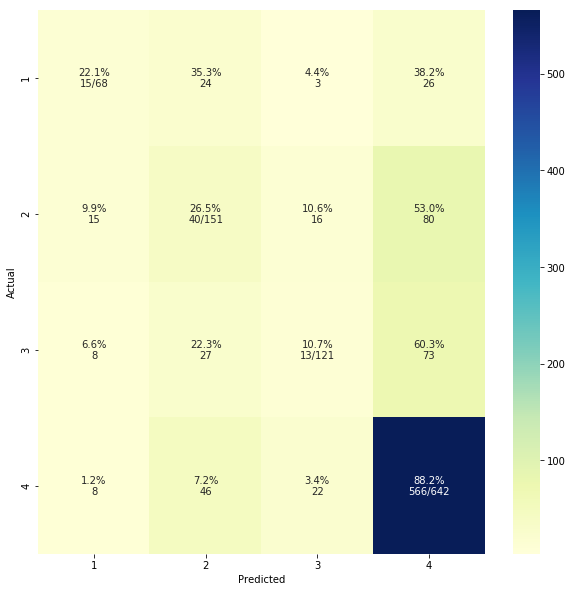

In [25]:
# This function is not my code, but is a regular confusion matrix plotting function I use
# https://www.kaggle.com/agungor2/various-confusion-matrix-plots

def plot_cm(y_true, y_pred, figsize=(10,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    
plot_cm(y_test, predictions)

From the confusion matrix can see the classifier is correctly predicting the majority class (class 4) in most instances. Its main issue is it also falsely classifies household poverty levels as level 4 when they are something else. 

# Conclusion and Next Steps
Significant effort in this exercise was given to finding and fixing data quality issues for the dataset. This allowed me to build a classifier that can predict the poverty level using both existing and newly engineered features.

The classifier's performance is measured by the F1 score, as per the Kaggle competition. It may be more interesting to look at recall and precision separately, particularly for the class which would be the target of the aid to evaluate this model. I also note that this has been treated as a multinomial classification problem, but the target (poverty level) is in fact a level variable. It is worse to misclassify a '1' as a '4' than it is a '3' as a '4'. Some thought should be given to how this could change our model design and evaluation. 

My immediate next steps to improve predictions would be:
* engineering new features at the household level, based on individuals.
* testing alternative classifiers e.g. KNN, SVMs or Neural Networks.
* more carefully imputing missing data.

Finally, further effort could be spent on reducing the number of features. We could do this by building up a set of non-collinear data sets from scratch; or using dimensionality reduction techniques such as PCA or T-SNE. This would allow us to use a wider set of models.